In [171]:
import math
import numpy as np
import pandas as pd
import random
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [350]:
def preprocessing(df):
    df["pick"] = df["pick"].notnull().astype('int')
    
    # Undersampling, too many people don't get drafted which makes for imbalanced classes
    # So delete some of the people who don't get drafted
    df = df.drop(df.query('pick == 0').sample(frac=.97).index)
    
    pick_df = df["pick"]
    
    df = df.drop(["yr", "ht", "num", "ast/tov", "rimmade", "rimmade+rimmiss", "midmade", "midmade+midmiss", 
                 "rimmade/(rimmade+rimmiss)", "midmade/(midmade+midmiss)", "dunksmade", "dunksmiss+dunksmade",
                 "dunksmade/(dunksmade+dunksmiss)", "Unnamed: 64", "Unnamed: 65", "pick", "team", "conf", 
                  "type", "year", "pid", "player_name"], axis=1)
    df["Rec Rank"] = df["Rec Rank"].fillna(0)
    train_mean = df.mean()
    df = df.dropna()

    train_min = df.min()
    train_max = df.max()
    df = (df - df.min()) / (df.max() - df.min())

    df["pick"] = pick_df
    
    return df, train_min, train_max, train_mean

def get_train_valid_split(df):
    train_df, valid_df = train_test_split(df, test_size=0.2)
    y_train_df = train_df["pick"]
    y_valid_df = valid_df["pick"]
    train_df = train_df.drop(["pick"], axis=1)
    valid_df = valid_df.drop(["pick"], axis=1)

    x_train = train_df.to_numpy()
    y_train = y_train_df.to_numpy()
    y_train = np.expand_dims(y_train, axis=1)
    x_valid = valid_df.to_numpy()
    y_valid = y_valid_df.to_numpy()
    y_valid = np.expand_dims(y_valid, axis=1)
    return x_train, y_train, x_valid, y_valid
    
df = pd.read_csv("data.csv")
df, train_min, train_max, train_mean = preprocessing(df)
x_train, y_train, x_valid, y_valid = get_train_valid_split(df)

/Users/ishaan/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Train Loss: 0.5051013113604412
Train Accuracy: 0.8242142025611175
Train F1 Score: 0.8133498145859085
Validation Loss: 0.49884268414749483
Validation Accuracy: 0.8294573643410853
Validation F1 Score: 0.8214285714285713


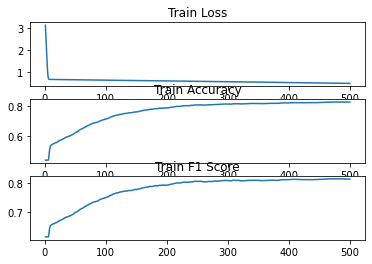

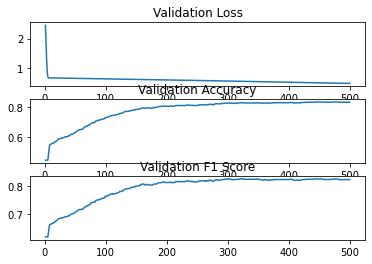

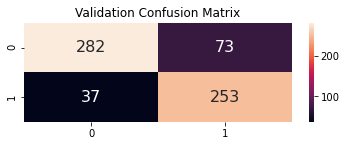

In [334]:
class MLP:
    
    def __init__(self, layers):
        self.layers = layers
        
    def __sigmoid(self, z):
        return 1/(1 + math.exp(-z))

    def __sigmoid_prime(self, z):
        return z * (1 - z)

    def __relu(self, z):
        return max(0, z)

    def __relu_prime(self, z):
        if z <= 0:
            return 0
        else:
            return 1

    def __binary_cross_entropy(self, y, y_hat):
        if y_hat == 1:
            if y == 1:
                return 0
            y_hat -= 1 * 10**-15
        return -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

    def __binary_cross_entropy_prime(self, y, y_hat):
        if y_hat == 1:
            y_hat -= 1 * 10**-15
        elif y_hat == 0:
            y_hat += 1 * 10**-15
        return -y / y_hat + (1 - y) / (1 - y_hat)

    def __compute_loss(self, y, y_hat):
        vectorized_binary_cross_entropy = np.vectorize(self.__binary_cross_entropy)
        loss = vectorized_binary_cross_entropy(y, y_hat).sum()
        return loss / len(y)
        
    def __initialize_matrices(self, x): 
        self.inputs = [x]
        self.activations = []
        self.weights = []
        self.biases = []
        for i in range(len(self.layers)):   
            if i != 0:
                i_matrix = np.zeros((len(x), self.layers[i]))
                self.inputs.append(i_matrix)

                a_matrix = np.zeros((len(x), self.layers[i]))
                self.activations.append(a_matrix)

                flat_matrix = np.random.rand(1, self.layers[i])
                b_matrix = flat_matrix
                for j in range(len(x) - 1):
                    b_matrix = np.vstack([b_matrix, flat_matrix])
                self.biases.append(b_matrix)

            if i != len(self.layers) - 1:
                w_matrix = np.random.rand(self.layers[i], self.layers[i + 1])
                self.weights.append(w_matrix)
        
    def __forward_propagation(self):
        vectorized_sigmoid = np.vectorize(self.__sigmoid)
        vectorized_relu = np.vectorize(self.__relu)

        for i in range(len(self.layers) - 1):
            if i == 0:
                z = np.dot(self.inputs[i], self.weights[i]) + self.biases[i]
            else:
                z = np.dot(self.activations[i - 1], self.weights[i]) + self.biases[i]
            self.inputs[i + 1] = z
            if i == len(self.layers) - 2:
                self.activations[i] = vectorized_sigmoid(z)
            else:
                self.activations[i] = vectorized_relu(z)
        
    def __gradient_descent(self, y):    
        vectorized_sigmoid_prime = np.vectorize(self.__sigmoid_prime)
        vectorized_relu_prime = np.vectorize(self.__relu_prime)
        vectorized_binary_cross_entropy_prime = np.vectorize(self.__binary_cross_entropy_prime)

        weights_gradient = []
        biases_gradient = []
        for i in range(len(self.weights) - 1, -1, -1):
            num_partials = 3 + 2 * (len(self.weights) - i - 1)
            w_partials = []
            b_partials = []
            for j in range(num_partials):
                if j == 0:
                    # dL/da
                    w_partial = vectorized_binary_cross_entropy_prime(y, self.activations[-1])
                    b_partial = w_partial

                elif j == num_partials - 1:
                    # dz/dw
                    index = len(self.activations) - math.ceil(j / 2) - 1
                    if index == -1:
                        a = self.inputs[0]
                    else:
                        a = self.activations[index]
                    w_partial = a

                    # dz/db
                    b_partial = np.array(1)

                elif j % 2 != 0:
                    # da/dz
                    a = self.activations[len(self.activations) - math.ceil(j / 2)]
                    if j == 1:
                        w_partial = vectorized_sigmoid_prime(a)
                    else:
                        w_partial = vectorized_relu_prime(a)
                    b_partial = w_partial

                else:
                    # dz/da_prev
                    z = self.inputs[len(self.inputs) - math.ceil(j / 2)]
                    w = self.weights[len(self.weights) - math.ceil(j / 2)]
                    w_partial = w.transpose()
                    b_partial = w_partial

                w_partials.append(w_partial)
                b_partials.append(b_partial)

            w_gradient = np.array(1)
            b_gradient = np.array(1)
            for j in range(0, len(w_partials) - 1, 2):
                w_gradient = np.dot(w_gradient, w_partials[j])
                w_gradient *= w_partials[j + 1]
                b_gradient = np.dot(b_gradient, b_partials[j])
                b_gradient *= b_partials[j + 1]

            w_gradient = np.dot(w_partials[-1].transpose(), w_gradient)
            w_gradient /= len(y)
            b_gradient *= b_partials[-1]
            b_gradient = np.mean(b_gradient, axis = 0)

            weights_gradient.append(w_gradient)
            biases_gradient.append(b_gradient)

        weights_gradient.reverse()
        biases_gradient.reverse()
        return weights_gradient, biases_gradient
        
    def __update_matrices(self, weights_gradient, biases_gradient):
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * weights_gradient[i]
            self.biases[i] -= self.lr * biases_gradient[i]
        
    def __predict(self, x):
        new_inputs = [x]
        new_activations = []
        new_biases = []
        for i in range(len(self.layers)):   
            if i != 0:
                i_matrix = np.zeros((len(x), self.layers[i]))
                new_inputs.append(i_matrix)

                a_matrix = np.zeros((len(x), self.layers[i]))
                new_activations.append(a_matrix)

                b_matrix = self.biases[i - 1][0]
                for j in range(len(x) - 1):
                    b_matrix = np.vstack([b_matrix, self.biases[i - 1][0]])
                new_biases.append(b_matrix)

        vectorized_sigmoid = np.vectorize(self.__sigmoid)
        vectorized_relu = np.vectorize(self.__relu)

        for i in range(len(self.layers) - 1):
            if i == 0:
                z = np.dot(new_inputs[i], self.weights[i]) + new_biases[i]
            else:
                z = np.dot(new_activations[i - 1], self.weights[i]) + new_biases[i]
            new_inputs[i + 1] = z
            if i == len(layers) - 2:
                new_activations[i] = vectorized_sigmoid(z)
            else:
                new_activations[i] = vectorized_relu(z)

        return new_activations[-1]
        
    def test(self, x):
        y = self.__predict(x)
        y = (y > 0.5).astype('int')
        return y
        
    def train(self, x_train, y_train, x_valid, y_valid, lr, num_epochs, verbose=True):
        self.lr = lr
        self.__initialize_matrices(x_train)

        losses = []
        accuracies = []
        f1_scores = []
        valid_losses = []
        valid_accuracies = []
        valid_f1_scores = []
        epochs = []
        y_hat_valid = 0
        for i in range(num_epochs):
            self.__forward_propagation()
            weights_gradient, biases_gradient = self.__gradient_descent(y_train)
            self.__update_matrices(weights_gradient, biases_gradient)

            loss = self.__compute_loss(y_train, self.activations[-1])        
            y_hat_train = (self.activations[-1] > 0.5).astype('int')
            accuracy = (y_train == y_hat_train).sum() / len(y_train)
            score = f1_score(y_train, y_hat_train)

            y_hat_valid = self.__predict(x_valid)
            valid_loss = self.__compute_loss(y_valid, y_hat_valid)
            y_hat_valid = (y_hat_valid > 0.5).astype('int')
            valid_accuracy = (y_valid == y_hat_valid).sum() / len(y_valid)
            valid_f1_score = f1_score(y_valid, y_hat_valid)

            losses.append(loss)
            accuracies.append(accuracy)
            f1_scores.append(score)
            valid_losses.append(valid_loss)
            valid_accuracies.append(valid_accuracy)
            valid_f1_scores.append(valid_f1_score)
            epochs.append(i + 1)

        if verbose:
            print("Train Loss:", losses[-1])
            print("Train Accuracy:", accuracies[-1])
            print("Train F1 Score:", f1_scores[-1])
            print("Validation Loss:", valid_losses[-1])
            print("Validation Accuracy:", valid_accuracies[-1])
            print("Validation F1 Score:", valid_f1_scores[-1])

            figure, axis = plt.subplots(3)
            axis[0].plot(epochs, losses)
            axis[0].set_title("Train Loss")
            axis[1].plot(epochs, accuracies)
            axis[1].set_title("Train Accuracy")
            axis[2].plot(epochs, f1_scores)
            axis[2].set_title("Train F1 Score")

            figure2, axis2 = plt.subplots(3)
            axis2[0].plot(epochs, valid_losses)
            axis2[0].set_title("Validation Loss")
            axis2[1].plot(epochs, valid_accuracies)
            axis2[1].set_title("Validation Accuracy")
            axis2[2].plot(epochs, valid_f1_scores)
            axis2[2].set_title("Validation F1 Score")

            cm = confusion_matrix(y_valid, y_hat_valid)
            df_cm = pd.DataFrame(cm)
            fig = plt.figure()
            ax1 = fig.add_subplot(211)
            sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, ax=ax1, fmt='g').set_title("Validation Confusion Matrix")
    
lr = 0.01
num_epochs = 500
layers = [x_train.shape[1], 4, 1]
mlp = MLP(layers)
mlp.train(x_train, y_train, x_valid, y_valid, lr, num_epochs)

In [353]:
og_test_df = pd.read_csv("prediction.csv")

test_df = og_test_df.drop(["yr", "ht", "num", "ast/tov", "rimmade", "rimmade+rimmiss", "midmade", "midmade+midmiss", 
             "rimmade/(rimmade+rimmiss)", "midmade/(midmade+midmiss)", "dunksmade", "dunksmiss+dunksmade",
             "dunksmade/(dunksmade+dunksmiss)", "Unnamed: 64", "Unnamed: 65", "pick", "team", "conf", 
              "type", "year", "pid", "player_name"], axis=1)
test_df["Rec Rank"] = test_df["Rec Rank"].fillna(0)
test_df = test_df.fillna(train_mean)

test_df = (test_df - train_min) / (train_max - train_min)

x_test = test_df.to_numpy()
pred = mlp.test(x_test)
players = np.where(pred == 1)[0]
drafted_df = og_test_df.iloc[players]
drafted_df.head()

,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,...,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65
1,Jalen Coleman-Lands,Kansas,B12,23,78.5,103.1,21.5,54.0,56.12,3.6,...,-1.019000,1.0435,2.8696,3.9130,1.1739,0.8261,0.0870,14.3043,Wing G,11.095900
2,K.J. Walton,Akron,MAC,20,63.0,108.6,26.5,54.3,58.88,9.1,...,-0.335789,2.3500,3.5500,5.9000,1.1500,1.2500,0.2000,16.3500,Wing G,0.284581
3,Jeriah Horne,Tulsa,Amer,32,61.3,116.0,20.8,55.2,58.61,5.8,...,1.721580,1.1250,4.7188,5.8438,0.9062,0.5938,0.0625,10.8125,Stretch 4,10.140700
7,Charlie Moore,Miami FL,ACC,16,67.1,96.3,26.6,47.4,50.23,2.5,...,-0.160305,0.7500,2.8750,3.6250,4.1875,1.0625,0.0000,14.3750,Scoring PG,8.913350
9,Keon Clergeot,Southeastern Louisiana,Slnd,24,72.7,101.5,25.9,47.1,57.34,2.6,...,-2.342450,0.7917,2.2500,3.0417,2.1667,1.0000,0.0833,15.8750,Combo G,6.731600
